# REFERENCES:
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

https://arxiv.org/pdf/1512.04150.pdf

https://pytorch.org/vision/stable/models.html

https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/05/27/extracting-features.html

https://medium.com/the-dl/how-to-use-pytorch-hooks-5041d777f904

In [1]:
import io
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import cv2
import json
from IPython import display 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import os

In [2]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        #Normalize
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

0.5392594933509827 -> ringlet
0.3346218764781952 -> monarch butterfly
0.0803930014371872 -> sulphur butterfly
0.016653314232826233 -> red admiral
0.007291491609066725 -> lacewing
0.006749697960913181 -> small white
0.005904683377593756 -> gossamer-winged butterfly
0.005501293111592531 -> bee
0.001139753614552319 -> cardoon
0.0005406474811024964 -> longhorn beetle
0.00045993374078534544 -> leaf beetle
0.0003809527843259275 -> hummingbird
0.0001943982351804152 -> fly
0.00012088708899682388 -> cricket
0.00011276978329988196 -> ladybug
8.371695730602369e-05 -> grasshopper
7.963037205627188e-05 -> partridge
7.305711187655106e-05 -> tiger beetle
6.321595719782636e-05 -> harvestman
5.1445407734718174e-05 -> ruffed grouse
4.05000573664438e-05 -> dragonfly
1.942910057550762e-05 -> weevil
1.9181457901140675e-05 -> pineapple
1.6892243365873583e-05 -> jaguar
1.2387421520543285e-05 -> mantis
1.1952115528401919e-05 -> leafhopper
1.1520048246893566e-05 -> European garden spider
1.123346828535432e-05 

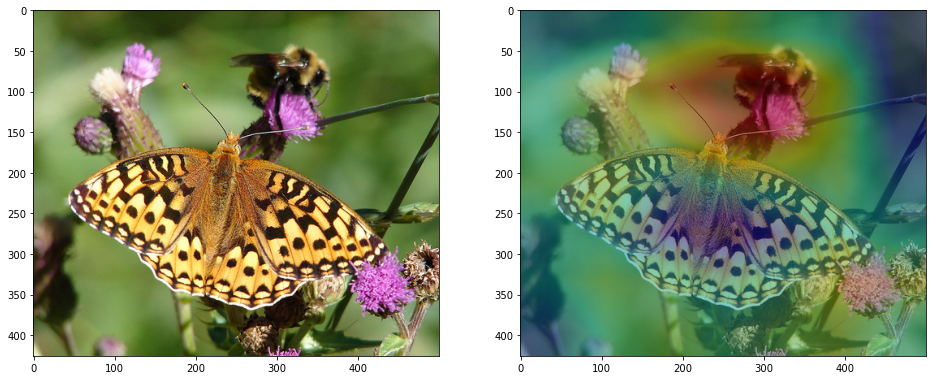

In [7]:
# input image
LABELS_file = 'imagenet-simple-labels.json'
#image_file = input("Name of input image: ")
image_file = "img11.jpg"
net = models.resnet18(pretrained=True)
finalconv_name = 'layer4'

#set the network in evaluation mode
net.eval()

# hook the feature extractor to be executed at forward pass
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

net._modules.get(finalconv_name).register_forward_hook(hook_feature)

# get the softmax weight
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

# load test image
img_pil = Image.open(image_file).convert('RGB')
img_tensor = preprocess(img_pil)
img_variable = Variable(img_tensor.unsqueeze(0))
logit = net(img_variable)

# load the imagenet category list
with open(LABELS_file) as f:
    classes = json.load(f)

h_x = F.softmax(logit, dim=1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

# output the prediction
for i in range(0, 1000):
    print('{} -> {}'.format(probs[i], classes[idx[i]]))

# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax,[309])

# render the CAM and output
print('output CAM.jpg for the top1 prediction: %s'%classes[309])
img = cv2.imread(image_file)
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
cv2.imwrite('CAM.jpg', result);
# figure size in inches optional
rcParams['figure.figsize'] = 16 ,9

# read images
img_A = mpimg.imread(image_file)
img_B = mpimg.imread("CAM.jpg")

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A);
ax[1].imshow(img_B);